### PCA Across Time  
  
This notebook is for reducing the row dimension of my EEGs. Each EEG has 200 rows of data per second. The first step is to figure out why scikit learn won't perform PCA on a transposed EEG. It wants to do PCA on the 20 electrodes whether they're the columns or the rows. One possible solution is to take individual electrodes separately and then stack them to fix the dimension issue scikit learn is having. So you'd have an Fp1 matrix, an Fp2 matrix, an F3 matrix, etc. You would then transpose these matrices. To help explain, in the Fp1 matrix, each row would be the Fp1 signal for a single sub EEG and the columns would be time. You could stack 10k Fp1 electrode signals and get a 10k by 10k matrix (10k columns because sub EEGs are 50 seconds long and the sampling frequency is 200).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

##### Loading and Splitting Data

In [3]:
df = pd.read_csv('working_data.csv')

def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

other_df = activity_df('Other')
seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')

##### Functions to Scale, Perform PCA, and Plot Signals

In [4]:
def scale(df, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(df['eeg_id'][row]), engine = 'pyarrow')
    first_row = int(df['eeg_label_offset_seconds'][row] * 200)
    last_row = int(first_row + 10000)
    sub_eeg = eeg[first_row: last_row]
    electrodes = sub_eeg.columns
    scaler = StandardScaler()
    sub_eeg = scaler.fit_transform(sub_eeg)
    sub_eeg = pd.DataFrame(sub_eeg, columns = electrodes)
    return sub_eeg

def activity_signal_plots(sub_eegs, activities, electrodes, h, w):
    fig, axs = plt.subplots(len(electrodes), len(sub_eegs))
    fig.set_figheight(h)
    fig.set_figwidth(w)
    fig.tight_layout()
    for i in range(len(electrodes)):
        if len(sub_eegs) == 1:
            axs[i].plot(sub_eegs[0][electrodes[i]])
            axs[i].set_title('{}_{}'.format(activities[0], electrodes[i]))
        else:
            for j in range(len(sub_eegs)):
                axs[i][j].plot(sub_eegs[j][electrodes[i]])
                if len(activities) > 1:
                    axs[i][j].set_title('{}_{}'.format(activities[j], electrodes[i]))
                else:
                    axs[i][j].set_title('{}_{}'.format(activities[0], electrodes[i]))
    plt.show()

def pca_function(sub_eeg, n):
    pca = PCA(n_components = n, random_state = 42)
    sub_eeg = pca.fit_transform(sub_eeg)
    ratios = pca.explained_variance_ratio_
    sub_eeg = pd.DataFrame(sub_eeg)
    return sub_eeg, ratios

In [5]:
sub_eeg1 = scale(df, 0)
sub_eeg2 = scale(df, 1)

In [6]:
pd.concat([sub_eeg1['Fp1'], sub_eeg2['Fp1']], axis = 1)

,Fp1,Fp1
0,1.399985,-0.460339
1,1.402654,-0.433345
2,1.411805,-0.428096
3,1.240225,-0.235017
4,1.016791,-0.471961
...,...,...
9995,-0.869440,-1.460599
9996,-1.331943,-1.938984
9997,-1.234714,-1.758278
9998,-0.366903,-1.908242


In [7]:
def electrode_matrices(electrode):
    indexes = [i for i in range(df.shape[0])]
    random_indexes = np.random.choice(indexes, size = 8000, replace = False)
    sub_eeg = scale(df, random_indexes[0])
    electrode_matrix = sub_eeg[electrode]
    for i in range(1, len(random_indexes)):
        sub_eeg = scale(df, random_indexes[i])
        electrode_matrix = pd.concat([electrode_matrix, sub_eeg[electrode]], axis = 1)
    electrode_matrix.columns = ['{}_{}'.format(random_indexes[i], electrode)
                                for i in range(len(random_indexes))]
    return electrode_matrix

### Fp1 Matrix  
  
The below code stacks 8000 random frontopolar electrodes in a single matrix for the purpose of doing PCA across the time dimension. Then PCA will be done reducing the 10k units of time to 1k. Then an elbow plot of the explained variance results will be made to get an idea of the best value for n_components. Afterwards, random electrodes from the matrix will be plotted to visualize the results.

In [8]:
fp1_matrix = electrode_matrices('Fp1')

In [9]:
fp1_matrix.head()

,73975_Fp1,79019_Fp1,5697_Fp1,68904_Fp1,20867_Fp1,59051_Fp1,71769_Fp1,82230_Fp1,43599_Fp1,20379_Fp1,...,20221_Fp1,25801_Fp1,65719_Fp1,26537_Fp1,34460_Fp1,6007_Fp1,67219_Fp1,62825_Fp1,74491_Fp1,35414_Fp1
0,-0.983092,0.036839,-2.182362,-0.756938,0.401416,-0.920239,0.212428,-0.815331,0.621733,-0.094825,...,-0.574392,-2.223705,0.027446,-1.016882,-0.365412,0.921855,0.256504,1.975540,0.832064,1.475027
1,-1.003358,0.255588,-2.173076,-0.505708,0.702163,-0.740656,0.225033,-0.743859,0.470998,-0.280821,...,-0.582315,-2.788347,-0.206332,-0.732169,-0.277555,0.984643,0.330866,1.817056,1.256598,0.995277
2,-0.687800,0.402278,-2.060607,-0.453379,0.915468,-0.736705,0.362110,-0.188327,0.319687,0.093117,...,-0.660222,-3.173108,-0.121117,-0.650102,-0.317383,2.071336,0.403952,1.859559,1.116438,0.512484
3,-0.837301,0.348433,-1.804198,-0.786913,0.992079,-0.673013,0.239213,-0.392997,0.136158,0.050069,...,-1.151724,-2.748311,-0.289295,-0.533481,-0.393916,1.397437,0.105864,1.875681,0.395135,0.339979
4,-1.544995,0.389708,-1.557076,-0.668029,1.276075,-0.660921,0.218730,-0.802742,0.173554,-0.311671,...,-1.112697,-2.928191,-0.539473,-0.884064,-0.255689,0.722174,0.127567,1.682510,0.801791,0.027754


In [10]:
fp1_matrix = fp1_matrix.transpose()

In [23]:
fp1_pca, fp1_variances = pca_function(fp1_matrix, 200)

In [24]:
fp1_pca.index = fp1_matrix.index

In [25]:
fp1_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
73975_Fp1,-0.609062,0.166684,18.446360,-26.861994,8.963130,19.064026,0.236034,3.409220,5.088690,2.324195,...,1.553037,-4.897677,4.898243,-9.083419,1.635858,4.004315,-6.050335,4.181498,-0.715334,-5.569355
79019_Fp1,-3.088847,-4.285110,35.510365,28.600485,-14.868493,-8.952903,-3.320958,10.159771,-4.664726,6.472688,...,-2.740504,-0.974241,-2.246612,-0.307369,-1.210882,3.425889,3.091537,0.344543,-1.491613,0.743012
5697_Fp1,0.953686,0.463730,-9.153485,10.693659,-5.117304,-24.312977,1.678114,-2.034544,-3.211874,-13.442906,...,0.255289,-2.116672,-0.718924,0.279921,1.787076,-0.042990,1.286124,-0.024909,-0.539365,-0.037705
68904_Fp1,-10.226152,-4.973672,-2.592864,-1.417227,-0.099245,-3.263061,-0.994895,-9.944265,-6.404315,-2.198224,...,0.642618,-4.569605,-2.540380,1.044092,7.107175,-1.742245,3.652047,-6.603259,2.598091,-8.817073
20867_Fp1,3.721802,-4.694401,-0.838513,-0.803187,-2.226274,4.267076,-1.276641,1.209325,2.513340,-0.605777,...,4.030282,0.900871,3.151109,-0.648912,-0.460086,-1.488526,-0.190136,-0.683717,-0.585366,3.382454


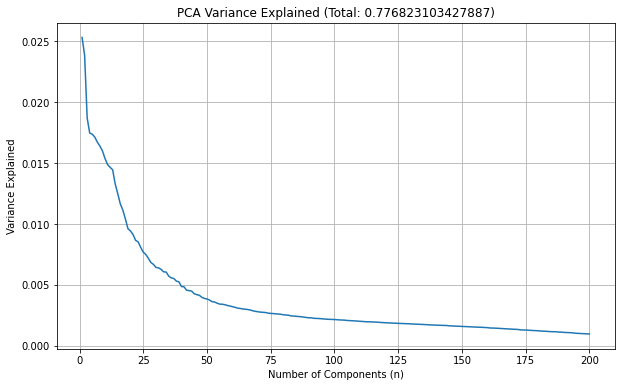

In [29]:
n_range = range(1, 201)
plt.figure(figsize = (10, 6))
plt.plot(n_range, fp1_variances)
plt.title('PCA Variance Explained (Total: {})'.format(fp1_variances.sum()))
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

In [30]:
totals = []
t = 0
for i in range(len(fp1_variances)):
    t += fp1_variances[i]
    totals.append(t)

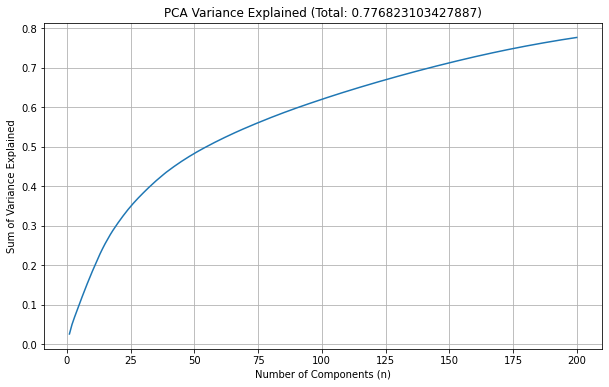

In [32]:
n_range = range(1, 201)
plt.figure(figsize = (10, 6))
plt.plot(n_range, totals)
plt.title('PCA Variance Explained (Total: {})'.format(fp1_variances.sum()))
plt.xlabel('Number of Components (n)')
plt.ylabel('Sum of Variance Explained')
plt.grid(True)
plt.show()

In [35]:
fp1_pca = fp1_pca.transpose()

In [37]:
fp1_list = fp1_pca.columns

In [39]:
fp1_col_numbers = [i for i in range(8000)]
to_plot = np.random.choice(fp1_col_numbers, size = 5, replace = False)

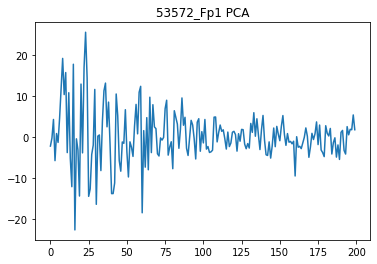

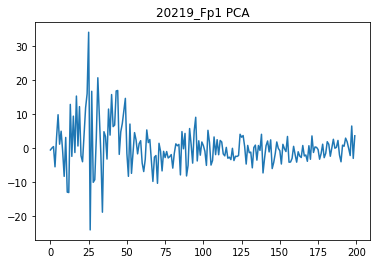

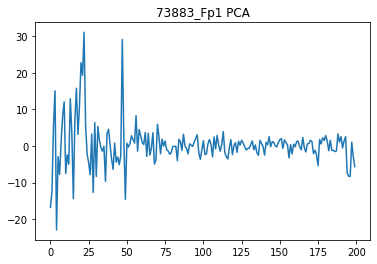

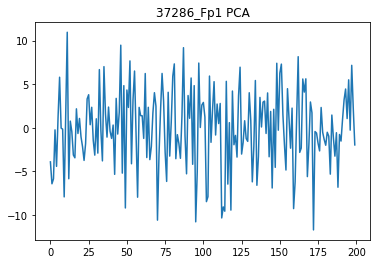

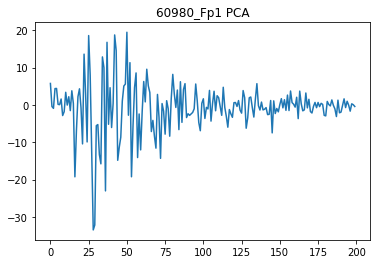

In [42]:
for i in to_plot:
    plt.plot(fp1_pca[fp1_list[i]])
    plt.title('{} PCA ({})'.format(fp1_list[i], ))
    plt.show()